# IT3 All (> 10 words) AND (thumbsup >1.0)

Coding was developed based on below sources:
* Brandonrose.org. (2018). Document Clustering with Python. [online] Available at: http://brandonrose.org/clustering 
* Scikit-learn.org. (2018). sklearn.metrics.silhouette_score — scikit-learn 0.19.2 documentation. [online] Available at: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
* Twitterdev.github.io. (2018). Do More with Twitter Data — Do more with Twitter data 0.1 documentation. [online] Available at: https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import mpld3
import sys
import csv
import string

In [6]:
dsa_data = pd.read_csv('/Users/rmhiwku/depression-stress-anxiety.csv')
dsa_data = dsa_data.dropna() #filter out empty rows; otherwise it will fail later
dsa_data.columns = ['appname', 'rating', 'ratingcount', 'developer','apptype','reviewer','date','reviewer_rating','thumbsup','review']
dsa_data['words'] = dsa_data['review'].str.split()
dsa_data['word_len'] = dsa_data['words'].str.len()
print('Total reviews: ',len(dsa_data))

#filter in only if >1 people gave thumbs-up
dsa_data_useful = dsa_data[dsa_data.thumbsup>1.0]
print('Total number of reviews users vote useful: ', len(dsa_data_useful))

#filter in only if length is >10 words
dsa_data_useful = dsa_data_useful[dsa_data_useful.word_len>13]
print('Total number of reviews user voted useful & long review: ', len(dsa_data_useful))

dsa_data_useful.head()

Total reviews:  63474
Total number of reviews users vote useful:  7917
Total number of reviews user voted useful & long review:  6225


appname  rating ratingcount developer  \
1   Moodpath - Depression & Anxiety Test     4.6       5,679  Moodpath   
3   Moodpath - Depression & Anxiety Test     4.6       5,679  Moodpath   
10  Moodpath - Depression & Anxiety Test     4.6       5,679  Moodpath   
11  Moodpath - Depression & Anxiety Test     4.6       5,679  Moodpath   
16  Moodpath - Depression & Anxiety Test     4.6       5,679  Moodpath   

    apptype        reviewer           date  reviewer_rating  thumbsup  \
1   Medical  Jessica Taylor  June 23, 2018              4.0       4.0   
3   Medical             L S  June 22, 2018              4.0       5.0   
10  Medical      Haley Rose  June 14, 2018              5.0       3.0   
11  Medical   A Google user  June 18, 2018              4.0       2.0   
16  Medical   A Google user  June 17, 2018              5.0       4.0   

                                               review  \
1   Review Text 2: Great app for keeping up with d...   
3   Review Text 4: Results were very helpful, exce...   
10  Review Text 11: I'm on my first day and I love...   
11  Review Text 12: Very helpful, great content, v...   
16  Review Text 17: Really helps me keep tract of ...   

                                                words  word_len  
1   [Review, Text, 2:, Great, app, for, keeping, u...        55  
3   [Review, Text, 4:, Results, were, very, helpfu...        68  
10  [Review, Text, 11:, I'm, on, my, first, day, a...        53  
11  [Review, Text, 12:, Very, helpful,, great, con...        35  
16  [Review, Text, 17:, Really, helps, me, keep, t...        32

In [9]:
appnames_all = dsa_data_useful['appname'].tolist()
reviews_all = dsa_data_useful['review'].tolist()

review_texts = reviews_all
print(len(review_texts))

6225


# Data Cleaning

In [11]:
# load NLTK's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['review','text','app',"also","would","stress","anxiety","depression","saying"]
stopwords.extend(newStopWords)
print (stopwords[:-1])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
# load NLTK's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [13]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [14]:
# use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in review_texts:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'review_texts', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

print("Number of vocab tokenized and stemmed: ", len(totalvocab_stemmed))
print("Number of vocab tokenized only: ",len(totalvocab_tokenized))

Number of vocab tokenized and stemmed:  118486
Number of vocab tokenized only:  118486


In [15]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 118486 items in vocab_frame


In [16]:
print (vocab_frame.head())

             words
great        great
keep       keeping
daili        daily
issu        issues
person  personally


In [17]:
# Count frequency of words
from collections import Counter
list1=totalvocab_stemmed
counts = Counter(list1)

print(counts)

Counter({'help': 2509, 'use': 1718, 'love': 1425, 'like': 1383, 'medit': 1342, 'realli': 1338, 'great': 1276, 'time': 1126, 'get': 1098, 'day': 907, 'one': 903, 'good': 879, 'work': 867, 'feel': 860, 'need': 786, 'tri': 741, 'make': 734, 'thank': 722, 'peopl': 700, 'much': 682, 'free': 625, 'thing': 573, 'even': 571, 'way': 542, 'want': 539, 'could': 502, 'give': 498, 'think': 495, 'listen': 486, 'pay': 462, 'keep': 453, 'better': 452, 'lot': 448, 'relax': 443, 'recommend': 436, 'well': 422, 'life': 422, 'start': 405, 'see': 388, 'talk': 381, 'thought': 377, 'mind': 377, 'therapist': 370, 'know': 369, 'amaz': 364, 'find': 358, 'first': 355, 'month': 353, 'mani': 352, 'best': 348, 'look': 343, 'back': 329, 'app': 327, 'problem': 325, 'calm': 323, 'easi': 322, 'subscript': 319, 'person': 313, 'everi': 309, 'pleas': 307, 'chang': 306, 'take': 301, 'voic': 298, 'track': 297, 'abl': 296, 'say': 291, 'differ': 290, 'someon': 289, 'nice': 288, 'still': 287, 'guid': 287, 'issu': 286, 'session'

# Tfidf Vectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.01, stop_words=stopwords,
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(review_texts) #fit the vectorizer to review_texts

print(tfidf_matrix.shape)

Wall time: 6.21 s
(6225, 366)


In [39]:
# Etermining what terms are useful enough to turn into features
terms = tfidf_vectorizer.get_feature_names()
print(len(terms))
terms

366


['abl',
 'absolut',
 'access',
 'account',
 'accur',
 'activ',
 'actual',
 'ad',
 'add',
 'advic',
 'afford',
 'ago',
 'allow',
 'almost',
 'alreadi',
 'alway',
 'amaz',
 'annoy',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'appreci',
 'around',
 'ask',
 'attack',
 'audio',
 'avail',
 'awar',
 'away',
 'awesom',
 'back',
 'background',
 'bad',
 'basic',
 'beauti',
 'becom',
 'believ',
 'best',
 'better',
 'bit',
 'bless',
 'breath',
 'bring',
 'bug',
 'buy',
 'calm',
 'care',
 'caus',
 'cbt',
 'chang',
 'charg',
 'chat',
 'check',
 'choos',
 'clear',
 'close',
 'come',
 'communiti',
 'complet',
 'concept',
 'connect',
 'constant',
 'content',
 'continu',
 'control',
 'cost',
 'could',
 'coupl',
 'cours',
 'crash',
 'creat',
 'custom',
 'daili',
 'data',
 'day',
 'deal',
 'definit',
 'delet',
 'depress',
 'design',
 'develop',
 'differ',
 'difficult',
 'disappoint',
 'doctor',
 'done',
 'download',
 'easi',
 'effect',
 'els',
 'email',
 'emot',
 'encourag',
 'end',
 'enjoy',
 'enough',
 '

In [40]:
# dist is defined as 1 - the cosine similarity of each document. 
# Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity 
# between each document and the other documents in the corpus (each review among the reviews). 
# Subtracting it from 1 provides cosine distance which is used for plotting on a euclidean (2-dimensional) plane.
from sklearn.metrics.pairwise import cosine_similarity
%time dist = 1 - cosine_similarity(tfidf_matrix)

Wall time: 653 ms


# K-means clustering

In [31]:
import pandas
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Elbow Curve - Finding the best parameter

Wall time: 6min 28s


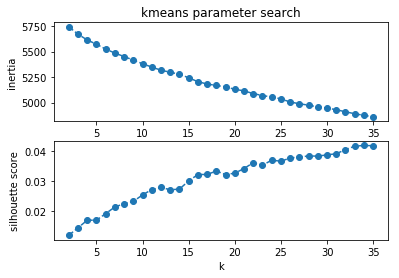

In [33]:
%%time

import logging
from sklearn.metrics import silhouette_score
seed = 42

# compare a broad range of ks to start
ks = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]


# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(tfidf_matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(tfidf_matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

Wall time: 4min 13s


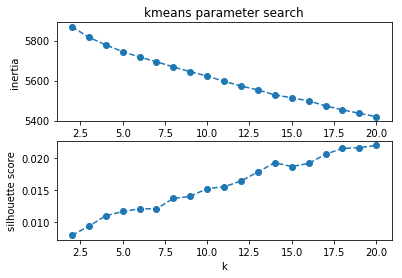

In [41]:
%%time

import logging
from sklearn.metrics import silhouette_score
seed = 42

# compare a broad range of ks to start
ks = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
      #,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]


# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(tfidf_matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(tfidf_matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

In [42]:
# Do KMeans clustering to get the clusters
#from sklearn.cluster import KMeans

num_clusters = 7

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 10.8 s


In [43]:
# Use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle
joblib.dump(km,  'doc_cluster3-1.pkl')

km = joblib.load('doc_cluster3-1.pkl')
clusters = km.labels_.tolist()

In [58]:
# Create dictionary
appreview = { 'review': review_texts, 'cluster': clusters}
frame = pd.DataFrame(appreview, index = [clusters] , columns = ['review','cluster'])

In [59]:
# Save clustered reviews to csv
frame.to_csv("IT3-1Sample.csv")

In [45]:
#number of reviews per cluster (clusters from 0 to 6)
frame['cluster'].value_counts()

2    2339
3     872
5     695
1     633
6     602
4     544
0     540
Name: cluster, dtype: int64

In [46]:
# indexing and sorting on each cluster to identify which are the top n (I used n=50) words that are nearest 
# to the cluster centroid. This gives a good sense of the main topic of the cluster.
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :50]: #replace with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        
    print() #add whitespace
    print() #add whitespace

print()

Top terms per cluster:

Cluster 0 words: pay, free, subscription, monthly, money, gets, like, pricing, one, much, want, great, year, day, content, cost, version, making, needs, expensive, using, buying, worked, people, trial, meditations, good, really, premium, charged, time, afford, paid,

C:\Users\rmhiwku\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


 worth, service, love, trying, pack, give, could, think, helpful, access, therapist, even, first, purchase, without, know, better,

Cluster 1 words: meditations, guide, great, day, like, love, using, trying, helpful, voice, really, mindfulness, gets, one, good, session, relax, free, starting, calm, time, making, headspace, thanks, practices, much, worked, recommend, minutes, best, feel, easy, daily, well, way, things, focusing, amazing, enjoying, music, needs, life, different, far, never, look, find, every, courses, effective,

Cluster 2 words: like, great, time, worked, gets, trying, good, listening, one, even, day, needs, thanks, way, making, could, therapist, rating, feel, people, want, give, things, better, keeping, fix, please, talking, says, problem, back, heart, well, think, screening, first, know, take, best, change, update, starting, see, reading, asking, life, open, prayers, nice, much,

Cluster 3 words: helpful, people, feel, thanks, great, lot, much, gets, needs, life, thou

# Multidimensional scaling

In [47]:
# convert the dist matrix into a 2-dimensional array using multidimensional scaling (MDS)
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()


Wall time: 25min 30s



In [48]:
#save nparray
import numpy
a = pos
numpy.savetxt("IT3POSnparray-1.csv", a, delimiter=",")

# Visualizing document clusters

In [49]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
                  5: '#5B1B9E', 6: '#9E1B7E', 7: '#9E1B22', 8: '#969E1B', 9: '#D3F22F',
                  10: '#F2602F', 11: '#50C7F4', 12: '#8ECE92', 13: '#E79FC0', 14: '#74045E',
                  15: '#EC86DD', 16: '#508DF4', 17: '#F4EB10', 18: '#C94E86', 19: '#5C45A5',
                  20: '#F0D0EB', 21: '#109C19', 22: '#E7E59F', 23: '#740437', 24: '#1AAEC3'}

#set up cluster names using a dict
cluster_names = {0: 'cluster1', 
                 1: 'cluster2', 
                 2: 'cluster3',
                 3: 'cluster4',
                 4: 'cluster5', 
                 5: 'cluster6', 
                 6: 'cluster7'}

### First, define some dictionaries for going from cluster number to color and to cluster name. Then, based the cluster names off the words that were closest to each cluster centroid.

C:\Users\rmhiwku\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


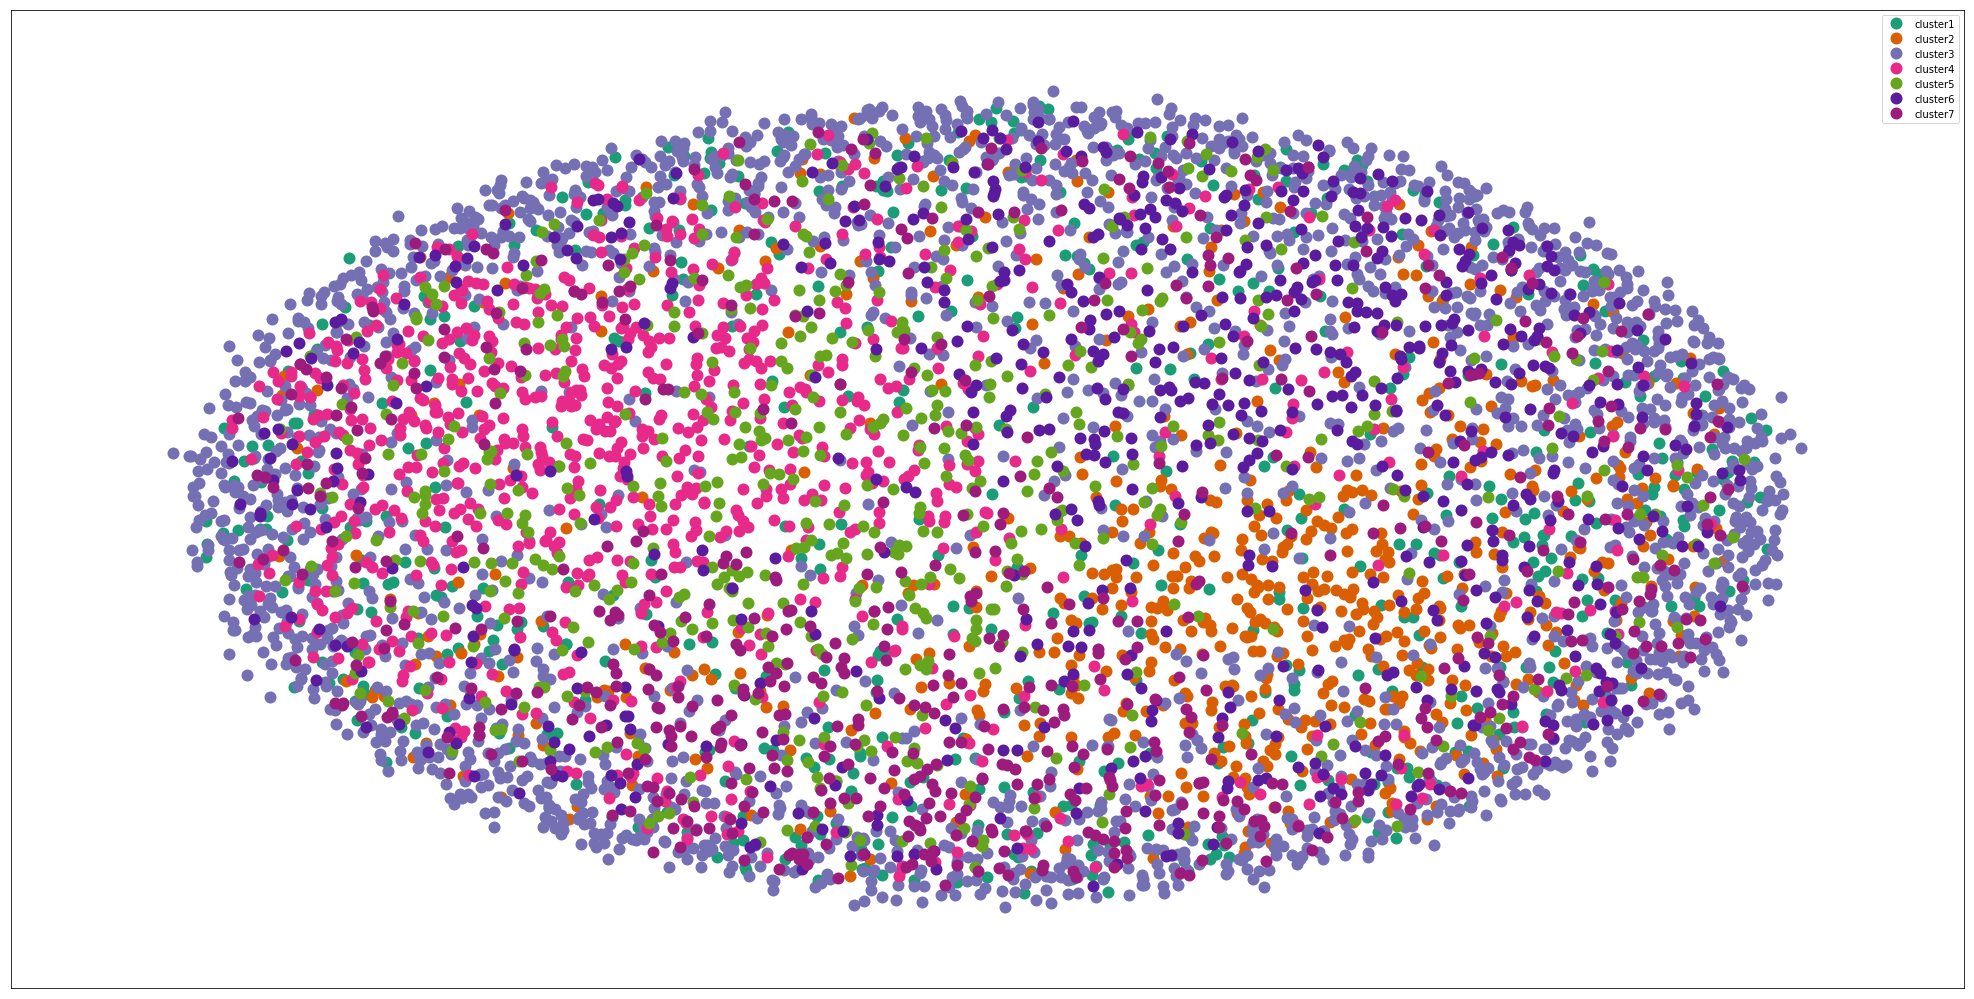

<Figure size 432x288 with 0 Axes>

In [79]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, review=review_texts)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(35, 18)) # set size
ax.margins(0.1) # add padding

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters.png', dpi=200)

In [ ]:
plt.close()